# Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import haversine as hv
from datetime import timedelta

In [5]:
train = pd.read_csv('train.csv')
weather = pd.read_csv('weather.csv')
spray = pd.read_csv('spray.csv')
test = pd.read_csv('test.csv')

In [164]:
train.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent'],
      dtype='object')

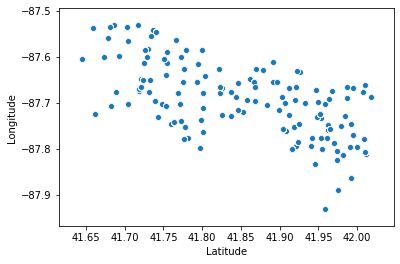

In [165]:
sns.scatterplot(x='Latitude',y='Longitude',data=train)

In [166]:
spray.columns

Index(['Date', 'Time', 'Latitude', 'Longitude'], dtype='object')

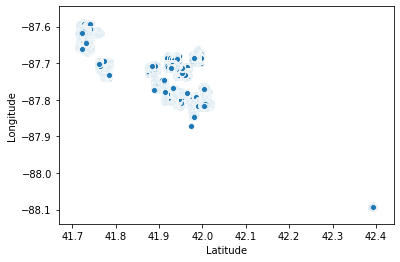

In [167]:
sns.scatterplot(x='Latitude',y='Longitude',data=spray)

In [168]:
train.dtypes

Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
NumMosquitos                int64
WnvPresent                  int64
dtype: object

In [169]:
spray = spray.drop_duplicates(subset=['Latitude', 'Longitude'], keep=False)

## Feature Engineering

Distance to nearest spray point within 3 days of each day.

In [6]:
spray.Date = spray.Date.astype('datetime64[ns]')
train.Date = train.Date.astype('datetime64[ns]')
test.Date = test.Date.astype('datetime64[ns]')

In [171]:
train.Date[1]

Timestamp('2007-05-29 00:00:00')

In [190]:
test.Date.head()

0   2008-06-11
1   2008-06-11
2   2008-06-11
3   2008-06-11
4   2008-06-11
Name: Date, dtype: datetime64[ns]

In [172]:
train.Date.head()

0   2007-05-29
1   2007-05-29
2   2007-05-29
3   2007-05-29
4   2007-05-29
Name: Date, dtype: datetime64[ns]

In [227]:
spray.Date.tail()

14830   2013-09-05
14831   2013-09-05
14832   2013-09-05
14833   2013-09-05
14834   2013-09-05
Name: Date, dtype: datetime64[ns]

In [229]:
start_date = test.Date[1]
end_date = start_date + timedelta(days=30)
mask = (start_date <= spray.Date ) & (spray.Date <= end_date)
spray_subset = spray[mask]
display(spray_subset)

,Date,Time,Latitude,Longitude,coords


In [175]:
spray['coords'] = spray.apply(lambda x: ([x.Latitude, x.Longitude]), axis=1)

In [233]:
def nearest_spray(date, in_coords, n_diff=7):
    
    
    start_date = date
    end_date = date + timedelta(days=n_diff)
    mask = (spray.Date >= start_date) & (spray.Date <= end_date)
    spray_subset = spray[mask]
    
    if not spray_subset.empty:
        dist = [hv.haversine(in_coords,coord) for coord in (spray_subset.coords)]     
        return round(min(dist),2)
    else:
        print('empty subset')
        return np.nan

In [179]:
%time
train['spray_dist'] = train.apply(lambda x: nearest_spray(x.Date,[x.Latitude, x.Longitude]), axis=1)
test['spray_dist'] = test.apply(lambda x: nearest_spray(x.Date,[x.Latitude, x.Longitude]), axis=1)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


In [185]:
## spray_status : 1 if less than 7 days and 3 km, else 0
train['spray_status'] = train.apply(lambda x: 1 if (x.spray_dist <= 3) else 0,axis=1)
test['spray_status'] = test.apply(lambda x: 1 if (x.spray_dist <= 3) else 0,axis=1)

In [182]:
train.spray_status.value_counts()

0    10208
1      298
Name: spray_status, dtype: int64

We can see that only 298 sites are covered under the spray conditions

In [240]:
test['year'] = test.Date.map(lambda x : x.year)
spray['year'] = spray.Date.map(lambda x: x.year)

In [241]:
spray.year.value_counts()

2013    12626
2011     1666
Name: year, dtype: int64

In [242]:
test.year.value_counts()

2010    36557
2008    30498
2012    27115
2014    22123
Name: year, dtype: int64

In [160]:
spray.count()

Date         14292
Time         13708
Latitude     14292
Longitude    14292
coords       14292
dtype: int64

In [244]:
weather.Date = weather.Date.astype('datetime64[ns]')

In [245]:
weather['year'] = weather.Date.map(lambda x : x.year)

In [248]:
weather.year.value_counts()

2013    368
2011    368
2009    368
2007    368
2014    368
2012    368
2010    368
2008    368
Name: year, dtype: int64

## Weather data Mapping

In [1]:
STATIONS = {
    1 : (41.995,-87.933),
    2 : (41.786,-87.752)
}

In [8]:
def nearest_station(in_coords):
    
    dist = {k:hv.haversine(in_coords,v) for k,v in STATIONS.items()}
    
    return min(dist, key=dist.get)


In [21]:
weather = pd.read_csv('weather_cleaned_stack_back.csv')
weather.drop(columns='Unnamed: 0',inplace=True)

In [23]:
weather.Date = weather.Date.astype('datetime64[ns]')
weather.head()

,Date,Sunset,DaylightHrs,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Station
0,2007-05-01,1849,1401,83.0,50.0,67.0,14.0,51.0,56.0,2.0,0.000,29.10,29.82,1.7,27.0,9.2,1
1,2007-05-02,1850,1403,59.0,42.0,51.0,-3.0,42.0,47.0,0.0,0.000,29.38,30.09,13.0,4.0,13.4,1
2,2007-05-03,1851,1405,66.0,46.0,56.0,2.0,40.0,48.0,0.0,0.000,29.39,30.12,11.7,7.0,11.9,1
3,2007-05-04,1852,1408,66.0,49.0,58.0,4.0,41.0,50.0,0.0,0.001,29.31,30.05,10.4,8.0,10.8,1
4,2007-05-05,1853,1410,66.0,53.0,60.0,5.0,38.0,49.0,0.0,0.001,29.40,30.10,11.7,7.0,12.0,1


In [9]:
train['nearest_station'] = train.apply(lambda x: nearest_station([x.Latitude, x.Longitude]), axis=1)

In [11]:
train.nearest_station.value_counts()

2    7208
1    3298
Name: nearest_station, dtype: int64

In [26]:
train.count()

Date                      10506
Address                   10506
Species                   10506
Block                     10506
Street                    10506
Trap                      10506
AddressNumberAndStreet    10506
Latitude                  10506
Longitude                 10506
AddressAccuracy           10506
NumMosquitos              10506
WnvPresent                10506
nearest_station           10506
dtype: int64

In [27]:
train_weather = train.merge(weather,left_on=['Date','nearest_station'],right_on=['Date','Station'])

In [31]:
train_weather.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'nearest_station', 'Sunset',
       'DaylightHrs', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'Station'],
      dtype='object')

In [ ]:
train_weather['month'] = train_weather.Date.map(lambda x : x.Month)

In [32]:
train_weather[['Species','NumMosquitos','Sunset',
       'DaylightHrs', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'Station']]

,Species,NumMosquitos,Sunset,DaylightHrs,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Station
0,CULEX PIPIENS/RESTUANS,1,1917,1496,88.0,60.0,74.0,10.0,58.0,65.0,9.0,0.00,29.39,30.11,5.8,18.0,6.5,1
1,CULEX RESTUANS,1,1917,1496,88.0,60.0,74.0,10.0,58.0,65.0,9.0,0.00,29.39,30.11,5.8,18.0,6.5,1
2,CULEX RESTUANS,1,1917,1496,88.0,60.0,74.0,10.0,58.0,65.0,9.0,0.00,29.39,30.11,5.8,18.0,6.5,1
3,CULEX PIPIENS/RESTUANS,1,1917,1496,88.0,60.0,74.0,10.0,58.0,65.0,9.0,0.00,29.39,30.11,5.8,18.0,6.5,1
4,CULEX RESTUANS,4,1917,1496,88.0,60.0,74.0,10.0,58.0,65.0,9.0,0.00,29.39,30.11,5.8,18.0,6.5,1
5,CULEX PIPIENS/RESTUANS,1,1917,1496,88.0,60.0,74.0,10.0,58.0,65.0,9.0,0.00,29.39,30.11,5.8,18.0,6.5,1
6,CULEX PIPIENS/RESTUANS,1,1917,1496,88.0,60.0,74.0,10.0,58.0,65.0,9.0,0.00,29.39,30.11,5.8,18.0,6.5,1
7,CULEX RESTUANS,2,1917,1496,88.0,65.0,77.0,13.0,59.0,66.0,12.0,0.00,29.44,30.09,5.8,16.0,7.4,2
8,CULEX RESTUANS,1,1917,1496,88.0,65.0,77.0,13.0,59.0,66.0,12.0,0.00,29.44,30.09,5.8,16.0,7.4,2
9,CULEX PIPIENS/RESTUANS,1,1917,1496,88.0,65.0,77.0,13.0,59.0,66.0,12.0,0.00,29.44,30.09,5.8,16.0,7.4,2
